In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from fuzzywuzzy import process,fuzz
from collections import defaultdict
from tqdm import tqdm
from scipy.interpolate import griddata
import os
import geopandas as gpd
import contextily as ctx  
from shapely.geometry import Point
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse

tqdm.pandas()

/opt/anaconda3/envs/diya_env/lib/python3.13/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from math import sqrt

# Latexify function with fallback fonts
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting."""
    assert(columns in [1,2])
    
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9  # width in inches
    
    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0
        fig_height = fig_width*golden_mean
    
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        fig_height = MAX_HEIGHT_INCHES
    
    params = {
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'font.size': 10,
        'legend.fontsize': 9,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif'],
        'lines.linewidth': 1,
        'axes.linewidth': 1,
        'patch.linewidth': 0.8,
        'xtick.major.width': 1,
        'ytick.major.width': 1,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
    }
    
    matplotlib.rcParams.update(params)

### Preprocess

In [5]:
city_tier_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ3/Dataset/city_tire.csv")
city_tier_df

,city,Tier
0,Bhilai,Tier2
1,Raipur,Tier2
2,Jaipur,Tier2
3,Navi Mumbai,Tier3
4,Pune,Tier1
...,...,...
284,Perundurai,Tier3
285,Pudukottai,Tier3
286,Madurai,Tier2
287,Ranipet,Tier3


In [6]:
gt_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/Ground_Truth_2023_Final.csv")

gt_df['year'] = pd.to_datetime(gt_df['YearMonth']).dt.year
gt_df['month'] = pd.to_datetime(gt_df['YearMonth']).dt.month_name()
print(gt_df.columns)
gt_df = gt_df[['city', 'state', 'year', 'month', 'PM2.5','latitude','longitude']].rename(columns={'PM2.5': 'ground_truth_pm25'})

gt_df

Index(['city', 'state', 'YearMonth', 'AT', 'BP', 'PM2.5', 'RF', 'VWS', 'WD',
       'WS', 'latitude', 'longitude', 'year', 'month'],
      dtype='object')


,city,state,year,month,ground_truth_pm25,latitude,longitude
0,Agartala,Tripura,2023,January,196.040103,23.817550,91.272697
1,Agartala,Tripura,2023,February,170.874875,23.817550,91.272697
2,Agartala,Tripura,2023,March,119.490881,23.817550,91.272697
3,Agartala,Tripura,2023,April,94.205356,23.817550,91.272697
4,Agartala,Tripura,2023,May,63.553585,23.817550,91.272697
...,...,...,...,...,...,...,...
2407,Yamuna Nagar,Haryana,2023,August,45.099735,30.148057,77.289347
2408,Yamuna Nagar,Haryana,2023,September,52.957552,30.148057,77.289347
2409,Yamuna Nagar,Haryana,2023,October,72.193644,30.148057,77.289347
2410,Yamuna Nagar,Haryana,2023,November,88.361732,30.148057,77.289347


In [7]:
gemma_9b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv")
gemma_27b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv")
llama_8b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv")
llama_70b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv")
qwen_14b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_14b_2023_predictions.csv")
qwen_32b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv")
gemini_flash_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemini_flash_2023.csv")
gpt_4o_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gpt_4o_pm25.csv")
cluade_sonnet_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/claude_sonnet_2023.csv")
# llama1_70b_df = pd.read_csv("AirQuality/RQ1/Dataset/llama3_1_70b_it_2023_predictions.csv")

In [5]:
gemma_9b_df.head()

,city,state,year,month,model,pm2.5
0,Agartala,Tripura,2023,January,google/gemma-2-9b-it,38.7
1,Agartala,Tripura,2023,February,google/gemma-2-9b-it,35.2
2,Agartala,Tripura,2023,March,google/gemma-2-9b-it,35.2
3,Agartala,Tripura,2023,April,google/gemma-2-9b-it,38.7
4,Agartala,Tripura,2023,May,google/gemma-2-9b-it,38.7


In [8]:
import numpy as np

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstrap=1000, alpha=0.05, random_state=0):
    """
    Generic non-parametric bootstrap CI for a scalar metric.
    metric_fn: function(y_true, y_pred) -> float
    Returns (lower, upper, std_boot).
    """
    rng = np.random.default_rng(random_state)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)

    stats = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    stats = np.array(stats)

    lower = np.percentile(stats, 100 * alpha / 2)
    upper = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower, upper, stats.std(ddof=1)

In [9]:
import numpy as np

def compute_metrics(
    df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    df = df.dropna(subset=["ground_truth_pm25", "pm2.5"])

    if df.empty:
        return {
            "MAE": np.nan,
            "Over %": np.nan,
            "Under %": np.nan,
            "MAEunder": np.nan,
            "MAEover": np.nan,
            "Samples": 0,
            # uncertainty
            "MAE_se": np.nan,
            "MAE_ci_low_param": np.nan,
            "MAE_ci_high_param": np.nan,
            "MAE_ci_low_boot": np.nan,
            "MAE_ci_high_boot": np.nan,
            "MAE_std_boot": np.nan,
        }

    gt = df["ground_truth_pm25"].to_numpy()
    pred = df["pm2.5"].to_numpy()
    n = len(df)

    abs_error = np.abs(gt - pred)
    mae = abs_error.mean()

    # -------- directional errors --------
    under_mask = pred < gt
    over_mask = pred > gt

    mae_under = abs_error[under_mask].mean() if under_mask.any() else np.nan
    mae_over  = abs_error[over_mask].mean()  if over_mask.any() else np.nan

    under_pct = 100 * under_mask.sum() / n
    over_pct  = 100 * over_mask.sum()  / n

    # ===================================
    # Uncertainty estimates for MAE
    # ===================================
    if n > 1:
        # 1) SE (MAE is mean of |error|)
        mae_se = abs_error.std(ddof=1) / np.sqrt(n)

        # 2) Parametric CI
        z = 1.96
        mae_ci_low_param = mae - z * mae_se
        mae_ci_high_param = mae + z * mae_se

        # 3) Bootstrap CI
        if n_bootstrap and n > 5:
            from numpy.random import default_rng
            rng = default_rng(random_state)

            stats = []
            for _ in range(n_bootstrap):
                idx = rng.integers(0, n, size=n)
                stats.append(np.mean(np.abs(gt[idx] - pred[idx])))
            stats = np.array(stats)

            mae_ci_low_boot = np.percentile(stats, 100 * alpha / 2)
            mae_ci_high_boot = np.percentile(stats, 100 * (1 - alpha / 2))
            mae_std_boot = stats.std(ddof=1)
        else:
            mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan
    else:
        mae_se = mae_ci_low_param = mae_ci_high_param = np.nan
        mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan

    return {
        "MAE": round(mae, 4),
        "Over %": round(over_pct, 4),
        "Under %": round(under_pct, 4),
        "MAEunder": round(mae_under, 4) if not np.isnan(mae_under) else np.nan,
        "MAEover": round(mae_over, 4) if not np.isnan(mae_over) else np.nan,
        "Samples": n,

        # uncertainty outputs (for bar plots)
        "MAE_se": mae_se,
        "MAE_ci_low_param": mae_ci_low_param,
        "MAE_ci_high_param": mae_ci_high_param,
        "MAE_ci_low_boot": mae_ci_low_boot,
        "MAE_ci_high_boot": mae_ci_high_boot,
        "MAE_std_boot": mae_std_boot,
    }

In [10]:
model_dfs = {
    "gemma2-9b-it": gemma_9b_df,
    "gemma2-27b-it": gemma_27b_df,
    # "llama-3.1-8b-Instruct": llama_8b_df,
    # "llama-3.1-70b-Instruct": llama1_70b_df,
    "llama3.3-70b-Instruct": llama_70b_df,
    "qwen3-14b": qwen_14b_df,
    "qwen3-32b": qwen_32b_df,
    "gemini-2.5-flash": gemini_flash_df,
    "gpt-4o": gpt_4o_df,
    "claude-sonnet-4.5" : cluade_sonnet_df
}

### Are Tier-3 cities are likely to be underpredicted or tier-1 cities are likely to be overpredicted?

In [13]:
def prepare_df(model_df, gt_df, city_tier_df):
    # print(model_df)
    model_df = model_df.copy()
    gt_df = gt_df.copy()
    city_tier_df = city_tier_df.copy()

    for df in [model_df, gt_df]:
        df["city"] = df["city"].str.strip().str.lower()
        df["state"] = df["state"].str.strip().str.lower()
        df["month"] = df["month"].str.strip().str.lower()
        df["year"] = df["year"].astype(int)

    city_tier_df["city"] = city_tier_df["city"].str.strip().str.lower()

    merged = pd.merge(model_df, gt_df, on=["city", "state", "year", "month"], how="inner")
    merged = pd.merge(merged, city_tier_df, on="city", how="left")
    merged["Tier"] = merged["Tier"].fillna("Unknown")

    return merged

#### Tier 1 VS 2 VS 3 

In [14]:
rows = []

for model_name, df in model_dfs.items():
    merged = prepare_df(df, gt_df, city_tier_df)

    for tier in ["tier1", "tier2", "tier3"]:
        tier_df = merged[merged["Tier"].str.lower() == tier]

        if len(tier_df) > 0:
            res = compute_metrics(tier_df)
            res["Model"] = model_name
            res["Tier"] = tier.replace("tier", "Tier ")
            rows.append(res)

tier_metrics_df = pd.DataFrame(rows)

# Optional: fix model order (for consistent plotting)
tier_metrics_df["Model"] = pd.Categorical(
    tier_metrics_df["Model"],
    categories=list(model_dfs.keys()),
    ordered=True,
)
tier_metrics_df = tier_metrics_df.sort_values(["Model", "Tier"])

In [15]:
tier_city_counts = {}
for tier_label in ["Tier 1", "Tier 2", "Tier 3"]:
    sub = tier_metrics_df[tier_metrics_df["Tier"] == tier_label]
    if not sub.empty:
        # Samples is per (model, tier); they should all be equal
        samples_one_model = sub["Samples"].iloc[0]
        tier_city_counts[tier_label] = int(samples_one_model / 12)
    else:
        tier_city_counts[tier_label] = 0

print(tier_city_counts)
# e.g. {'Tier 1': 23, 'Tier 2': 45, 'Tier 3': 31}

{'Tier 1': 8, 'Tier 2': 66, 'Tier 3': 127}


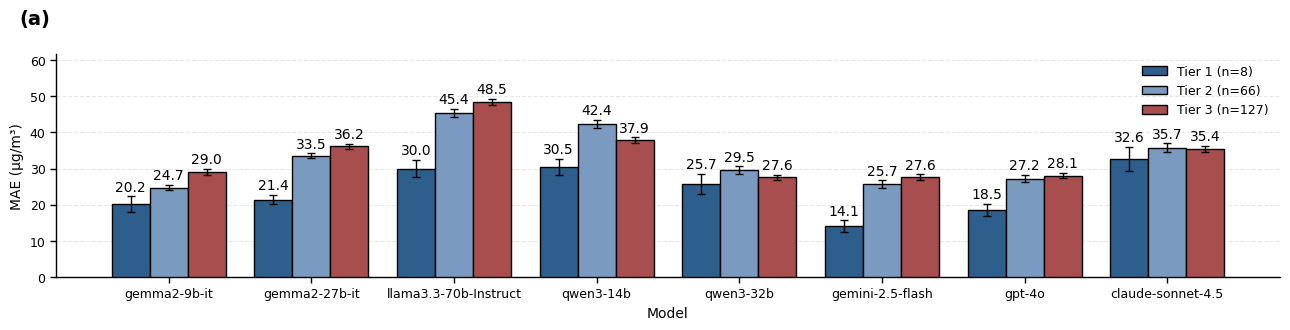

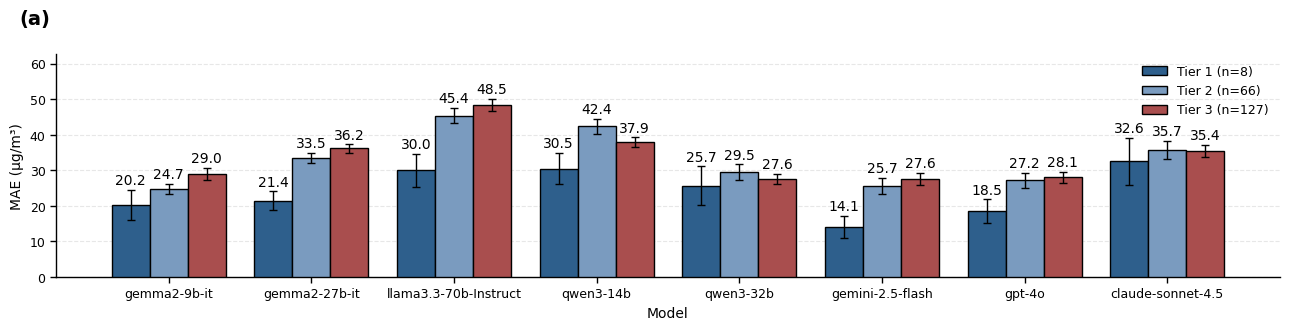

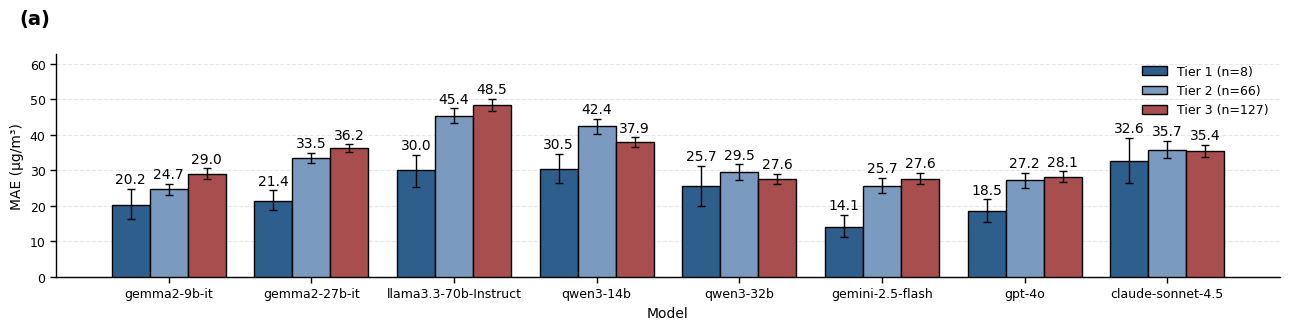

In [94]:
# assuming tier_metrics_df and tier_city_counts already computed
latexify(columns=2,fig_width=13,fig_height=3.5)
# 1) MAE ± SE
plot_tier_mae_uncertainty(
    tier_metrics_df,
    tier_city_counts=tier_city_counts,
    err_type="se",
    save_path="tier_mae_se.pdf",
)

# 2) MAE with parametric 95% CI
plot_tier_mae_uncertainty(
    tier_metrics_df,
    tier_city_counts=tier_city_counts,
    err_type="param_ci",
    save_path="tier_mae_param_ci.pdf",
)

# 3) MAE with bootstrap 95% CI
plot_tier_mae_uncertainty(
    tier_metrics_df,
    tier_city_counts=tier_city_counts,
    err_type="boot_ci",
    save_path="tier_mae_boot_ci.pdf",
)

In [11]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

def build_tier_samecity_metrics(
    model_dfs,
    gt_df,
    city_tier_df,
    n_cities_match=8,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    """
    Experiment: Tier 1 vs Tier 3 with the same city count for both tiers.

    - Tier 1: all Tier-1 cities (as-is; currently 8 cities in your dataset).
    - Tier 3: a fixed subset of `n_cities_match` Tier-3 cities that are present
      for ALL models. This subset is chosen once and used for all models.

    Returns a DataFrame with rows:
        (Model, Tier="Tier 1") and (Model, Tier="Tier 3"),
    plus MAE and uncertainty columns from compute_metrics.
    """
    rng = default_rng(random_state)

    # ----- find Tier-3 cities that are common to all models -----
    common_tier3_cities = None

    for model_name, model_df in model_dfs.items():
        merged = prepare_df(model_df, gt_df, city_tier_df)
        tier3_df = merged[merged["Tier"].str.lower() == "tier3"]
        cities_t3 = set(tier3_df["city"].unique())

        if common_tier3_cities is None:
            common_tier3_cities = cities_t3
        else:
            common_tier3_cities = common_tier3_cities.intersection(cities_t3)

    if not common_tier3_cities or len(common_tier3_cities) < n_cities_match:
        raise ValueError(
            f"Not enough common Tier-3 cities across models: "
            f"needed {n_cities_match}, found {0 if not common_tier3_cities else len(common_tier3_cities)}"
        )

    common_tier3_cities = list(common_tier3_cities)
    # choose ONE fixed subset of Tier-3 cities to use for all models
    sampled_cities_t3 = rng.choice(common_tier3_cities, size=n_cities_match, replace=False)

    rows = []

    for model_name, model_df in model_dfs.items():
        merged = prepare_df(model_df, gt_df, city_tier_df)

        # --- Tier 1: all Tier-1 cities ---
        tier1_df = merged[merged["Tier"].str.lower() == "tier1"]
        if len(tier1_df) > 0:
            m1 = compute_metrics(
                tier1_df,
                n_bootstrap=n_bootstrap,
                alpha=alpha,
                random_state=random_state,
            )
            m1["Model"] = model_name
            m1["Tier"] = "Tier 1"
            rows.append(m1)

        # --- Tier 3: fixed subset of Tier-3 cities (same subset for all models) ---
        tier3_df = merged[merged["Tier"].str.lower() == "tier3"]
        fixed_subset_df = tier3_df[tier3_df["city"].isin(sampled_cities_t3)]

        if len(fixed_subset_df) == 0:
            continue

        m3 = compute_metrics(
            fixed_subset_df,
            n_bootstrap=n_bootstrap,
            alpha=alpha,
            random_state=random_state,
        )
        m3["Model"] = model_name
        m3["Tier"] = "Tier 3"

        # Optionally enforce Samples ≈ n_cities_match * 12, or just keep len(df)
        # Here we keep the real number of rows.
        rows.append(m3)

    samecity_df = pd.DataFrame(rows)

    # Fix model ordering
    samecity_df["Model"] = pd.Categorical(
        samecity_df["Model"],
        categories=list(model_dfs.keys()),
        ordered=True,
    )
    samecity_df = samecity_df.sort_values(["Model", "Tier"])

    return samecity_df

In [16]:
tier_metrics_samecity_df = build_tier_samecity_metrics(
    model_dfs,
    gt_df,
    city_tier_df,
    n_cities_match=8,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tier_mae_uncertainty(
    tier_metrics_df,
    tier_city_counts=None,
    err_type="se",      # "se", "param_ci", "boot_ci"
    save_path=None,
):
    df = tier_metrics_df.copy()

    # infer groups from data instead of hard-coding Tier 1/2/3
    groups = list(df["Tier"].unique())

    # assign colors per group (extendable)
    base_colors = ["#2E5F8C", "#A94E4E", "#7A9BBF", "#8C2E5F"]
    colors = {g: base_colors[i % len(base_colors)] for i, g in enumerate(groups)}

    # model order
    if hasattr(df["Model"], "cat"):
        model_order = list(df["Model"].cat.categories)
    else:
        model_order = list(df["Model"].unique())

    df = df.set_index("Model").loc[model_order].reset_index()

    x = np.arange(len(model_order))
    width = 0.8 / len(groups)

    # auto-compute city counts from Samples (assuming 12 months per city)
    if tier_city_counts is None:
        tier_city_counts = {}
        for g in groups:
            sub = df[df["Tier"] == g]
            if sub.empty or "Samples" not in sub.columns:
                tier_city_counts[g] = np.nan
            else:
                samples = sub["Samples"].iloc[0]
                if samples <= 0 or np.isnan(samples):
                    tier_city_counts[g] = np.nan
                else:
                    tier_city_counts[g] = int(round(samples / 12.0))

    legend_labels = {
        g: f"{g} (n={tier_city_counts.get(g, np.nan)})" for g in groups
    }

    def get_error(g):
        mean = g["MAE"].to_numpy()

        if err_type == "se":
            err = g["MAE_se"].to_numpy()
            return err, err
        elif err_type == "param_ci":
            low = g["MAE_ci_low_param"].to_numpy()
            high = g["MAE_ci_high_param"].to_numpy()
        elif err_type == "boot_ci":
            low = g["MAE_ci_low_boot"].to_numpy()
            high = g["MAE_ci_high_boot"].to_numpy()
        else:
            raise ValueError("Invalid err_type")

        return mean - low, high - mean

    # y-axis upper bound
    if err_type == "se":
        y_max = np.nanmax(df["MAE"] + df["MAE_se"])
    elif err_type == "param_ci":
        y_max = np.nanmax(df["MAE_ci_high_param"])
    else:
        y_max = np.nanmax(df["MAE_ci_high_boot"])

    y_offset = y_max * 0.03

    fig, ax = plt.subplots()

    # ----- Bars + error bars -----
    for i_group, group in enumerate(groups):
        g = df[df["Tier"] == group].copy()
        g = g.set_index("Model").loc[model_order]

        xpos = x - 0.4 + i_group * width + width / 2
        heights = g["MAE"].to_numpy()
        err_low, err_high = get_error(g)

        ax.bar(
            xpos,
            heights,
            width,
            label=legend_labels[group],
            color=colors[group],
            edgecolor="black",
            linewidth=1.0,
            zorder=3,
        )

        ax.errorbar(
            xpos,
            heights,
            yerr=np.vstack([err_low, err_high]),
            fmt="none",
            capsize=3,
            color="black",
            linewidth=1.0,
            zorder=5,
        )

        for xp, h, eh in zip(xpos, heights, err_high):
            ax.text(xp, h + eh + y_offset, f"{h:.1f}", ha="center")

    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_xlabel("Model")
    ax.set_ylabel("MAE (µg/m³)")

    ax.set_ylim(0, y_max * 1.25)
    ax.legend(frameon=False, loc="upper right")

    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1)
    ax.spines["bottom"].set_linewidth(1)
    ax.set_axisbelow(True)

    ax.text(
        -0.03, 1.2, "(b)",
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=14,
        fontweight="bold"
    )

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, format="pdf", bbox_inches="tight")

    plt.show()

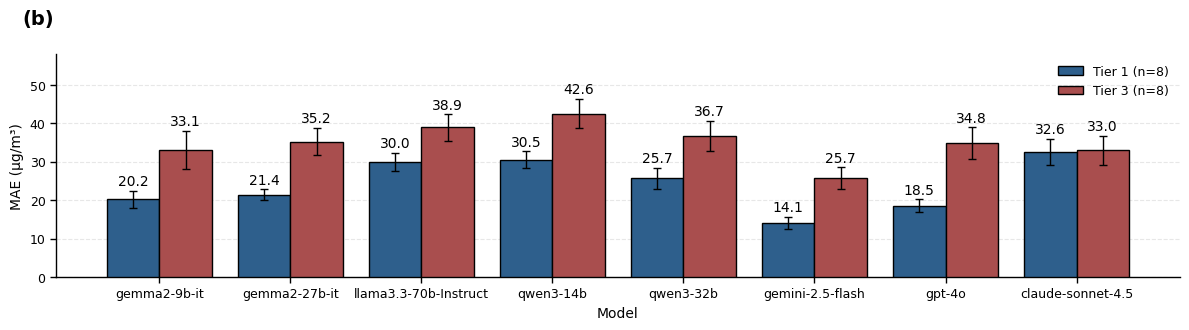

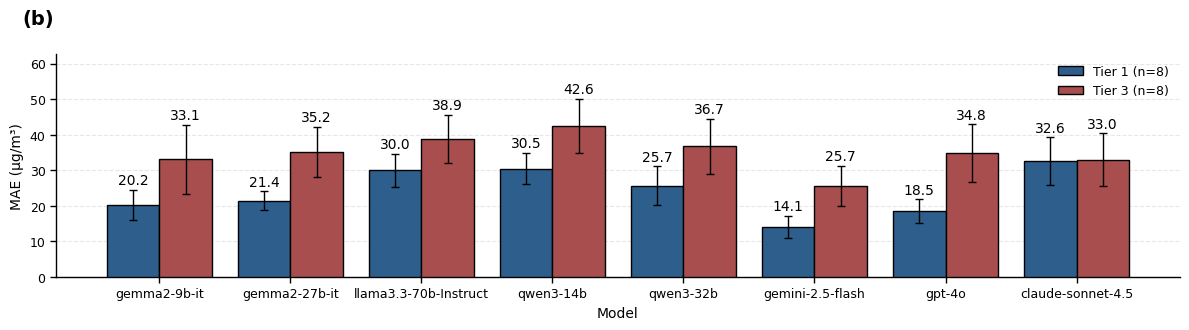

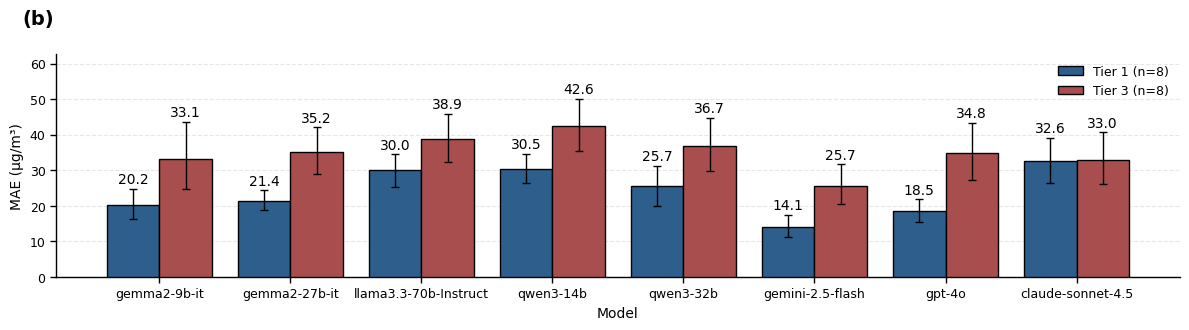

In [21]:
latexify(columns=2, fig_width=12, fig_height=3.5)

# SE bars
plot_tier_mae_uncertainty(
    tier_metrics_samecity_df,
    err_type="se",
    # save_path="tier_samecity_mae_se.pdf",
)

# parametric CI bars
plot_tier_mae_uncertainty(
    tier_metrics_samecity_df,
    err_type="param_ci",
    # save_path="tier_samecity_mae_param_ci.pdf",
)

# bootstrap CI bars
plot_tier_mae_uncertainty(
    tier_metrics_samecity_df,
    err_type="boot_ci",
    save_path="tier_samecity_mae_boot_ci.pdf",
)


### Are poor cities are more likely to be underpredicted?

In [98]:
mpi_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ3/Dataset/mpi_2023.csv")

mpi_df.head()

,district,mpi,state
0,Anantapur,0.027,Andhra Pradesh
1,Chittoor,0.022,Andhra Pradesh
2,East Godavari,0.027,Andhra Pradesh
3,Guntur,0.016,Andhra Pradesh
4,Krishna,0.017,Andhra Pradesh


In [12]:
print(mpi_df['mpi'].min())
print(mpi_df['mpi'].max())
print(mpi_df['mpi'].nunique())

0.0
0.285
181


In [13]:
mpi_df.columns

Index(['district', 'mpi', 'state'], dtype='object')

In [59]:
# Assuming your DataFrame is named `mpi_df` and has columns: 'city', 'state', 'mpi'

# Round MPI to 3 decimal places if it's a float with too much precision
mpi_df['mpi'] = mpi_df['mpi'].round(3)

# Count number of cities per unique MPI value
mpi_counts = mpi_df.groupby('mpi')['district'].nunique().reset_index(name='num_cities')

# Sort by MPI (optional)
mpi_counts = mpi_counts.sort_values('mpi').reset_index(drop=True)

In [15]:
mpi_counts

,mpi,num_cities
0,0.000,5
1,0.001,4
2,0.002,3
3,0.003,3
4,0.004,10
...,...,...
176,0.252,1
177,0.262,2
178,0.266,1
179,0.281,1


In [60]:
import matplotlib.pyplot as plt
import numpy as np
from fuzzywuzzy import fuzz
import pandas as pd

# Prepare MPI data
mpi_df["state"] = mpi_df["state"].str.lower().str.strip()
mpi_df["district"] = mpi_df["district"].str.lower().str.strip()

def get_mpi(row):
    city = row["city"].lower().strip()
    state = row["state"].lower().strip()
    candidates = mpi_df[mpi_df["state"] == state]
    
    if candidates.empty:
        return np.nan
    
    candidates = candidates.copy()
    candidates["score"] = candidates["district"].apply(lambda d: fuzz.token_sort_ratio(d, city))
    
    best_match = candidates.loc[candidates["score"].idxmax()]
    if best_match["score"] >= 80: 
        return best_match["mpi"]
    else:
        return np.nan

# Combine all models
model_all = []
for model_name, model_df in model_dfs.items():
    df = model_df.copy()
    df["model"] = model_name
    model_all.append(df)

all_models_df = pd.concat(model_all, ignore_index=True)

# Merge with ground truth
merged_df = pd.merge(all_models_df, gt_df, on=["city", "state", "year", "month"], how="inner")

# Apply MPI using fuzzy matching
print("Matching city ↔ district with fuzzy logic...")
merged_df["mpi"] = merged_df.progress_apply(get_mpi, axis=1)

# Drop rows where MPI couldn't be determined
merged_df = merged_df.dropna(subset=["mpi"])

# Calculate and display MPI statistics
print("\n=== MPI Statistics ===")
print(f"MPI Range: {merged_df['mpi'].min():.4f} to {merged_df['mpi'].max():.4f}")
print(f"MPI Median: {merged_df['mpi'].median():.4f}")
print(f"MPI Mean: {merged_df['mpi'].mean():.4f}")

# Use MEDIAN as threshold for balanced comparison
threshold = merged_df['mpi'].median()
print(f"\nUsing Median Threshold: {threshold:.4f}")

# Split into Low and High MPI based on median
low_mpi_df = merged_df[merged_df["mpi"] < threshold]
high_mpi_df = merged_df[merged_df["mpi"] >= threshold]

Matching city ↔ district with fuzzy logic...


  0%|          | 0/19295 [00:00<?, ?it/s]

100%|██████████| 19295/19295 [00:24<00:00, 773.68it/s]


=== MPI Statistics ===
MPI Range: 0.0000 to 0.2660
MPI Median: 0.0300
MPI Mean: 0.0523

Using Median Threshold: 0.0300


In [64]:
import numpy as np
import pandas as pd

def build_mpi_metrics(
    merged_df,
    threshold=None,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    """
    Build a metrics dataframe with one row per (Model, MPI Group),
    using your compute_metrics function.

    merged_df must have at least:
        - 'model'
        - 'mpi'
        - 'city'
        - 'ground_truth_pm25'
        - 'pm2.5'
    """

    df = merged_df.copy()

    # 1) Define threshold if not given
    if threshold is None:
        threshold = df["mpi"].median()

    # 2) Create MPI Group column
    df["MPI Group"] = np.where(df["mpi"] < threshold, "Low MPI", "High MPI")

    # 3) City counts per group (for legend)
    n_low = df[df["MPI Group"] == "Low MPI"]["city"].nunique()
    n_high = df[df["MPI Group"] == "High MPI"]["city"].nunique()
    mpi_city_counts = {"Low MPI": n_low, "High MPI": n_high}

    # 4) Model order
    if hasattr(df["model"], "cat"):
        model_order = list(df["model"].cat.categories)
    else:
        model_order = list(df["model"].unique())

    group_order = ["Low MPI", "High MPI"]
    groups = [g for g in group_order if g in df["MPI Group"].unique()]

    rows = []
    for model_name in model_order:
        for group in groups:
            sub = df[(df["model"] == model_name) & (df["MPI Group"] == group)]
            if sub.empty:
                continue

            m = compute_metrics(
                sub,
                n_bootstrap=n_bootstrap,
                alpha=alpha,
                random_state=random_state,
            )
            m["Model"] = model_name
            m["MPI Group"] = group
            rows.append(m)

    mpi_metrics_df = pd.DataFrame(rows)

    # enforce consistent model ordering
    mpi_metrics_df["Model"] = pd.Categorical(
        mpi_metrics_df["Model"],
        categories=model_order,
        ordered=True,
    )
    mpi_metrics_df = mpi_metrics_df.sort_values(["Model", "MPI Group"])

    return mpi_metrics_df, mpi_city_counts

In [66]:
mpi_metrics_df, mpi_city_counts = build_mpi_metrics(
    merged_df,
    threshold=None,      # or set your own threshold
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
)

print(mpi_city_counts)


{'Low MPI': 60, 'High MPI': 65}


In [99]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mpi_mae_uncertainty(
    mpi_metrics_df,
    mpi_city_counts=None,
    err_type="se",   # "se", "param_ci", "boot_ci"
    save_path=None,
):
    df = mpi_metrics_df.copy()

    # fixed order
    group_order = ["Low MPI", "High MPI"]
    groups = [g for g in group_order if g in df["MPI Group"].unique()]

    colors = {
        "Low MPI": "#3D5A7B",
        "High MPI": "#A94E4E",
    }

    # model order
    if hasattr(df["Model"], "cat"):
        model_order = list(df["Model"].cat.categories)
    else:
        model_order = list(df["Model"].unique())

    df = df.set_index("Model").loc[model_order].reset_index()

    x = np.arange(len(model_order))
    width = 0.8 / len(groups)

    # legend labels
    if mpi_city_counts is None:
        mpi_city_counts = {g: np.nan for g in groups}

    legend_labels = {
        g: f"{g} (n={mpi_city_counts.get(g, np.nan)})" for g in groups
    }

    def get_error(g):
        mean = g["MAE"].to_numpy()

        if err_type == "se":
            err = g["MAE_se"].to_numpy()
            return err, err
        elif err_type == "param_ci":
            low = g["MAE_ci_low_param"].to_numpy()
            high = g["MAE_ci_high_param"].to_numpy()
        elif err_type == "boot_ci":
            low = g["MAE_ci_low_boot"].to_numpy()
            high = g["MAE_ci_high_boot"].to_numpy()
        else:
            raise ValueError("Invalid err_type")

        return mean - low, high - mean

    # y-axis upper bound
    if err_type == "se":
        y_max = np.nanmax(df["MAE"] + df["MAE_se"])
    elif err_type == "param_ci":
        y_max = np.nanmax(df["MAE_ci_high_param"])
    else:
        y_max = np.nanmax(df["MAE_ci_high_boot"])

    y_offset = y_max * 0.03

    fig, ax = plt.subplots()

    # ----- bars + error bars -----
    for i_group, group in enumerate(groups):
        g = df[df["MPI Group"] == group].copy()
        g = g.set_index("Model").loc[model_order]

        xpos = x - 0.4 + i_group * width + width / 2
        heights = g["MAE"].to_numpy()
        err_low, err_high = get_error(g)

        ax.bar(
            xpos,
            heights,
            width,
            label=legend_labels[group],
            color=colors[group],
            edgecolor="black",
            linewidth=1.0,
            zorder=3,
        )

        ax.errorbar(
            xpos,
            heights,
            yerr=np.vstack([err_low, err_high]),
            fmt="none",
            capsize=3,
            color="black",
            linewidth=1.0,
            zorder=5,
        )

        for xp, h, eh in zip(xpos, heights, err_high):
            ax.text(xp, h + eh + y_offset, f"{h:.1f}", ha="center")

    diff_df = (
        df.pivot(index="Model", columns="MPI Group", values="MAE")
    )


    y_diff = y_max * 0.02

    for i, model in enumerate(model_order):
        if "Low MPI" in diff_df.columns and "High MPI" in diff_df.columns:
            diff = diff_df.loc[model, "High MPI"] - diff_df.loc[model, "Low MPI"]
            ax.text(
                i,
                y_diff,
                f"Diff: {diff:+.1f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="white",
                fontweight="bold",
                zorder=6,
            )

    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_xlabel("Model")
    ax.set_ylabel("MAE (µg/m³)")

    ax.set_ylim(0, y_max * 1.25)
    ax.legend(frameon=False, loc="upper right")

    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1)
    ax.spines["bottom"].set_linewidth(1)
    ax.set_axisbelow(True)

    ax.text(
        -0.03, 1.2, "(b)",
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=14,
        fontweight="bold"
    )

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, format="pdf", bbox_inches="tight")

    plt.show()

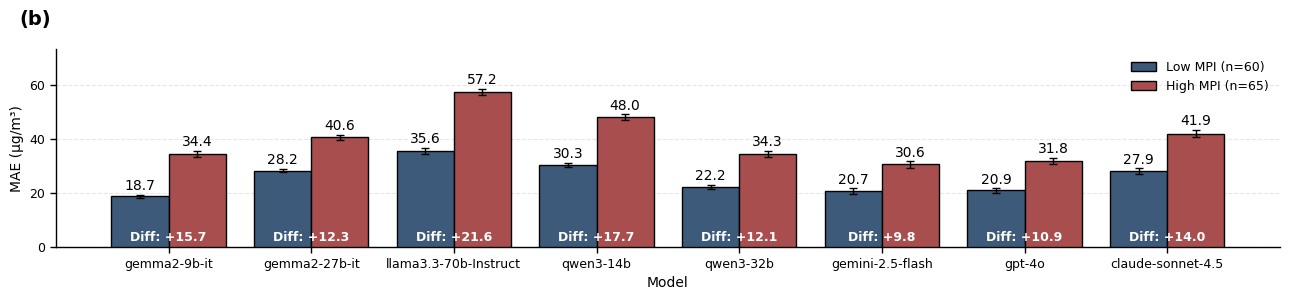

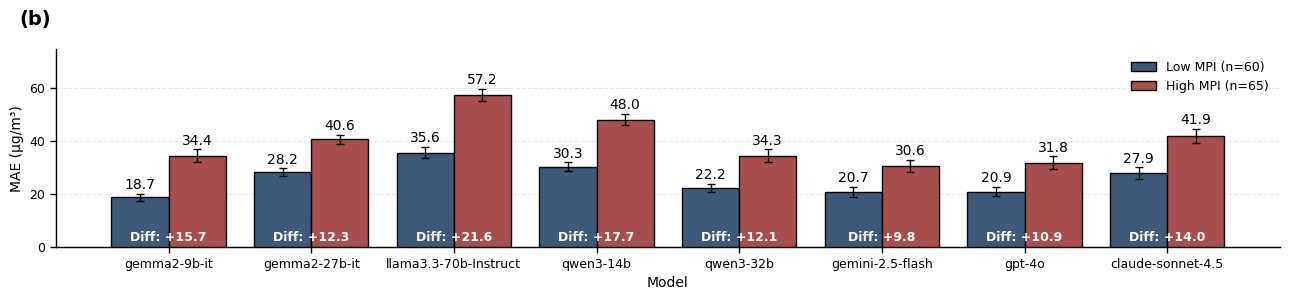

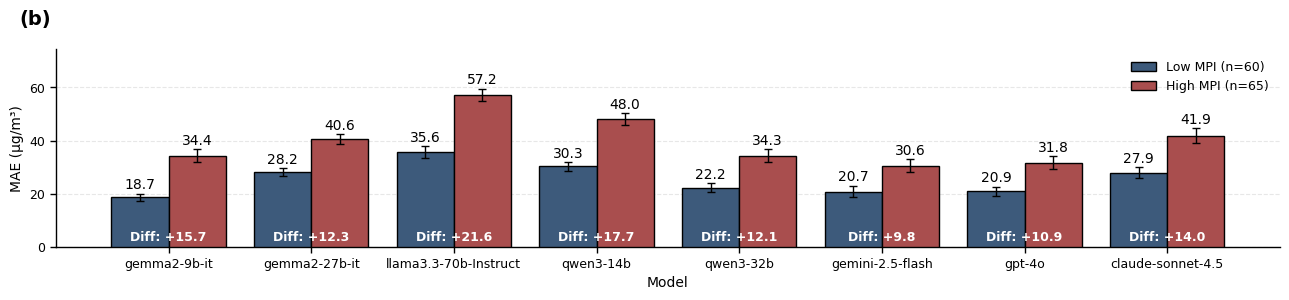

In [101]:
latexify(columns=2, fig_height=3.2, fig_width=13)

# 1) MAE ± SE
plot_mpi_mae_uncertainty(
    mpi_metrics_df,
    mpi_city_counts=mpi_city_counts,
    err_type="se",
    # save_path="mpi_mae_se.pdf",
)

# 2) MAE with parametric 95% CI
plot_mpi_mae_uncertainty(
    mpi_metrics_df,
    mpi_city_counts=mpi_city_counts,
    err_type="param_ci",
    # save_path="mpi_mae_param_ci.pdf",
)

# 3) MAE with bootstrap 95% CI
plot_mpi_mae_uncertainty(
    mpi_metrics_df,
    mpi_city_counts=mpi_city_counts,
    err_type="boot_ci",
    save_path="mpi_mae_boot_ci.pdf",
)


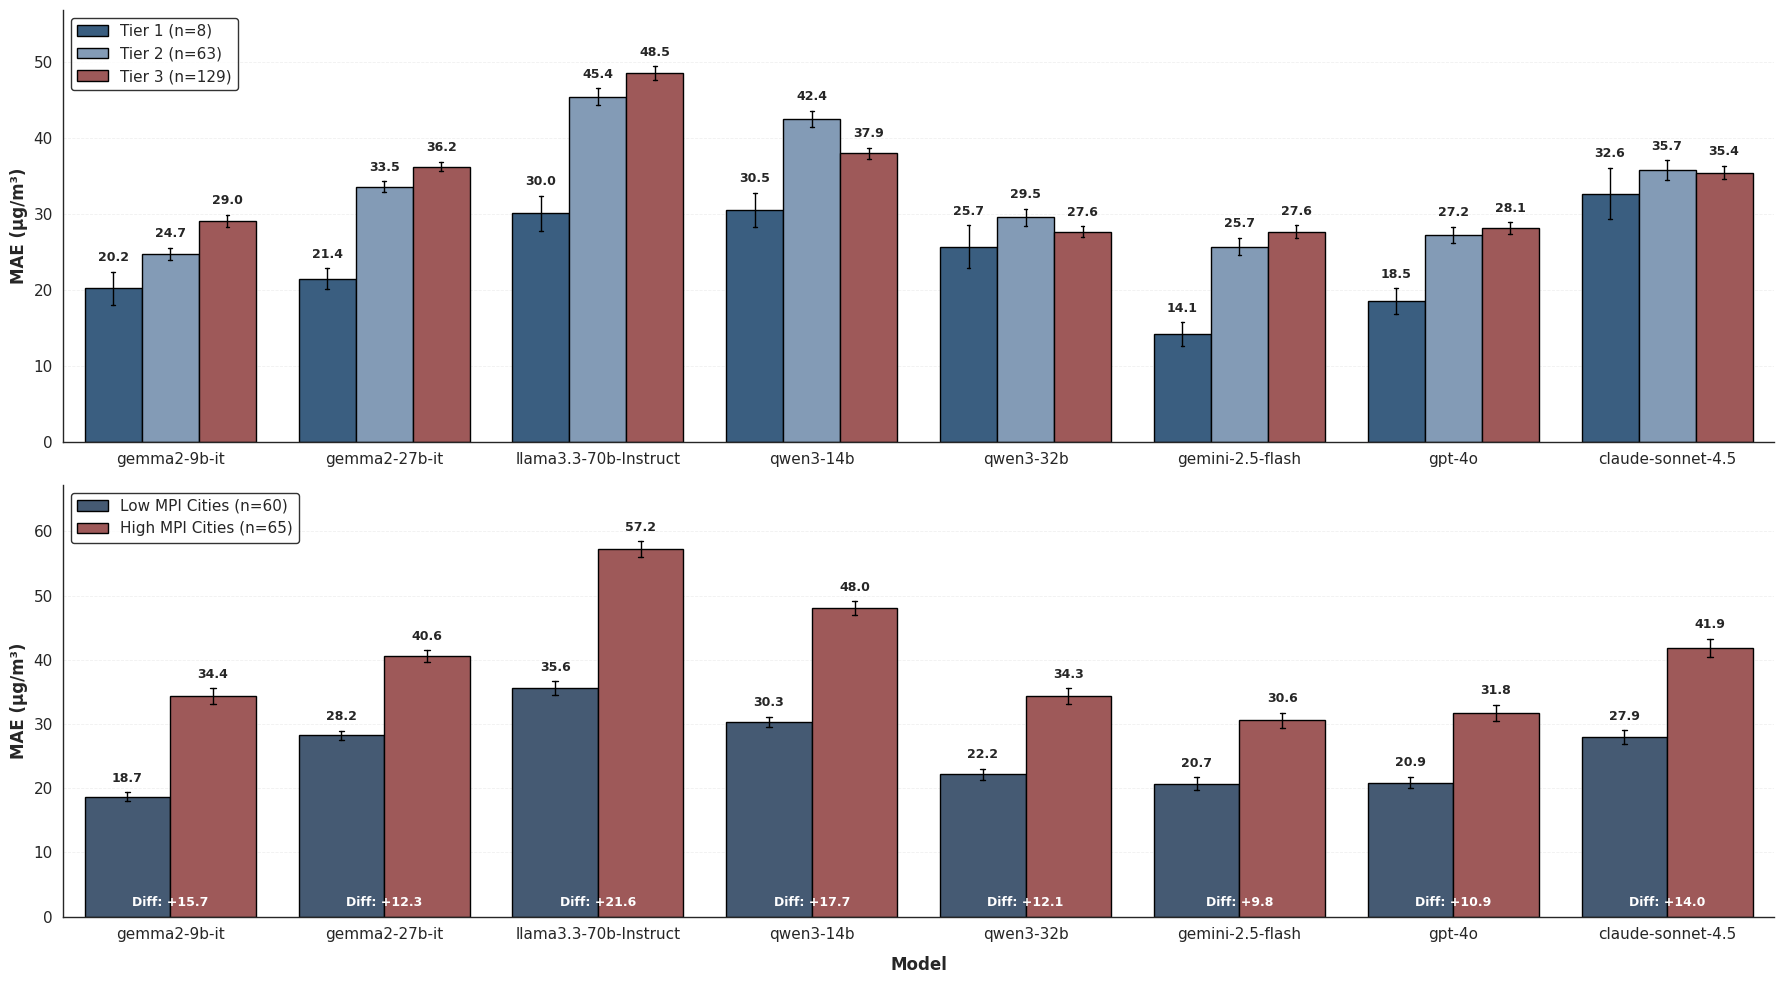

In [27]:
# ---------------------------
# Combined Figure: 2 rows x 1 column
# ---------------------------

# 0) Ensure latexify / seaborn theme set once
latexify(columns=2, fig_height=5)   # keep your latexify call (adjusts rcparams)
sns.set_theme(style="white")

# ==========================================
# 1) DATA PROCESSING FOR TIER PLOT (unchanged logic)
# ==========================================
tier_data_rows = []

# Build long dataframe with abs_error per city-month for every model
for model_name, df in model_dfs.items():
    merged = prepare_df(df.copy(), gt_df.copy(), city_tier_df.copy())
    merged['abs_error'] = (merged['pm2.5'] - merged['ground_truth_pm25']).abs()
    merged['Model'] = model_name

    # Standardize Tier names
    merged['Tier'] = merged['Tier'].str.strip().str.lower().replace({
        'tier1': 'Tier 1',
        'tier2': 'Tier 2',
        'tier3': 'Tier 3'
    })

    # Filter valid tiers
    merged = merged[merged['Tier'].isin(['Tier 1', 'Tier 2', 'Tier 3'])]

    # Keep necessary columns
    tier_data_rows.append(merged[['Model', 'Tier', 'abs_error', 'city']])

# Combine
tier_stats_long = pd.concat(tier_data_rows, ignore_index=True)

# Summary stats (mean + SE)
tier_summary_df = tier_stats_long.groupby(['Model', 'Tier'])['abs_error'].agg(
    MAE_mean='mean',
    MAE_se=lambda x: x.std() / np.sqrt(len(x))
).reset_index()

tier_summary_df_indexed = tier_summary_df.set_index(['Model', 'Tier'])

# City counts per tier
n_tier1 = tier_stats_long[tier_stats_long['Tier'] == 'Tier 1']['city'].nunique()
n_tier2 = tier_stats_long[tier_stats_long['Tier'] == 'Tier 2']['city'].nunique()
n_tier3 = tier_stats_long[tier_stats_long['Tier'] == 'Tier 3']['city'].nunique()

legend_labels = {
    "Tier 1": f"Tier 1 (n={n_tier1})",
    "Tier 2": f"Tier 2 (n={n_tier2})",
    "Tier 3": f"Tier 3 (n={n_tier3})"
}

tier_order = ['Tier 1', 'Tier 2', 'Tier 3']
palette = {"Tier 1": "#2E5F8C", "Tier 2": "#7A9BBF", "Tier 3": "#A94E4E"}

# ==========================================
# 2) DATA PROCESSING FOR MPI PLOT (unchanged logic; avoid name collision)
# ==========================================
# Note: `threshold` and `merged_df` are assumed to already exist in your session.
# If `threshold` is not defined earlier, define it here (example default). Comment/remove if already defined:
# threshold = 0.5

# Assign MPI groups
merged_df['MPI Group'] = np.where(merged_df['mpi'] < threshold, 'Low MPI', 'High MPI')

# Absolute error needed for SE
merged_df['abs_error'] = (merged_df['pm2.5'] - merged_df['ground_truth_pm25']).abs()

# Summary stats for MPI groups
mpi_summary_df = merged_df.groupby(['model', 'MPI Group'])['abs_error'].agg(
    MAE_mean='mean',
    MAE_se=lambda x: x.std() / np.sqrt(len(x))
).reset_index()

# Compute difference High - Low per model and merge back
pivot_diff = mpi_summary_df.pivot(index='model', columns='MPI Group', values='MAE_mean')
pivot_diff['MAE_Diff'] = pivot_diff['High MPI'] - pivot_diff['Low MPI']
mpi_summary_df = pd.merge(mpi_summary_df, pivot_diff['MAE_Diff'].reset_index(), on='model', how='left')

mpi_summary_df_indexed = mpi_summary_df.set_index(['model', 'MPI Group'])

# Counts per MPI group
n_low = merged_df[merged_df['MPI Group'] == 'Low MPI']['city'].nunique()
n_high = merged_df[merged_df['MPI Group'] == 'High MPI']['city'].nunique()

# Use a different name to avoid overwriting `legend_labels` from tier plot
legend_labels_mpi = {
    "Low MPI": f"Low MPI Cities (n={n_low})",
    "High MPI": f"High MPI Cities (n={n_high})"
}

group_order = ['Low MPI', 'High MPI']
palette_mpi = {"Low MPI": "#3D5A7B", "High MPI": "#A94E4E"}

# ==========================================
# 3) PLOTTING BOTH SUBPLOTS (2 rows x 1 column)
# ==========================================
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=False)  # Two rows, one column

# ---------- Top subplot: Tier barplot ----------
ax = axes[0]

barplot_tier = sns.barplot(
    data=tier_stats_long,
    x='Model',
    y='abs_error',
    hue='Tier',
    hue_order=tier_order,
    errorbar='se',
    palette=palette,
    capsize=0.05,
    err_kws={'linewidth': 1.0, 'color': 'black', 'zorder': 5},
    edgecolor='black', linewidth=1.0, width=0.8, ax=ax
)

# Dynamic label positioning for the tier plot
visual_model_order_tier = [label.get_text() for label in ax.get_xticklabels()]

max_val_tier = (tier_summary_df['MAE_mean'] + tier_summary_df['MAE_se']).max()
ax.set_ylim(0, max_val_tier * 1.15)
ax.set_xlim(-0.5, len(visual_model_order_tier) - 0.5)

y_offset_tier = max_val_tier * 0.02

for i, container in enumerate(ax.containers):
    if i >= len(tier_order):
        break
    group_name = tier_order[i]

    for j, bar in enumerate(container):
        model_name = visual_model_order_tier[j]

        try:
            mean_val = tier_summary_df_indexed.loc[(model_name, group_name), 'MAE_mean']
            se_val = tier_summary_df_indexed.loc[(model_name, group_name), 'MAE_se']

            y_pos = mean_val + se_val + y_offset_tier

            ax.text(
                bar.get_x() + bar.get_width() / 2,
                y_pos,
                f'{mean_val:.1f}',
                ha='center', va='bottom',
                fontsize=9, fontweight='bold', zorder=6
            )
        except KeyError:
            continue

# Styling for top subplot
ax.set_ylabel('MAE (µg/m³)', fontsize=12, fontweight='bold')
ax.set_xlabel('')  # no x label for top plot
handles_t, labels_t = ax.get_legend_handles_labels()
new_labels_t = [legend_labels[l] for l in labels_t]
ax.legend(handles_t, new_labels_t, fontsize=11, loc='upper left', frameon=True, shadow=False, edgecolor='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.set_axisbelow(True)
ax.tick_params(labelsize=11, width=1.0, length=4)

# ---------- Bottom subplot: MPI barplot ----------
ax2 = axes[1]

barplot_mpi = sns.barplot(
    data=merged_df,
    x='model',
    y='abs_error',
    hue='MPI Group',
    hue_order=group_order,
    errorbar='se',
    palette=palette_mpi,
    capsize=0.05,
    err_kws={'linewidth': 1.0, 'color': 'black', 'zorder': 5},
    edgecolor='black', linewidth=1.0, width=0.8, ax=ax2
)

# Dynamic label positioning for MPI plot
visual_model_order_mpi = [label.get_text() for label in ax2.get_xticklabels()]

max_val_mpi = (mpi_summary_df['MAE_mean'] + mpi_summary_df['MAE_se']).max()
ax2.set_ylim(0, max_val_mpi * 1.15)
ax2.set_xlim(-0.5, len(visual_model_order_mpi) - 0.5)

y_offset_mpi = max_val_mpi * 0.02

for i, container in enumerate(ax2.containers):
    if i >= len(group_order):
        break
    group_name = group_order[i]

    for j, bar in enumerate(container):
        model_name = visual_model_order_mpi[j]

        try:
            mean_val = mpi_summary_df_indexed.loc[(model_name, group_name), 'MAE_mean']
            se_val = mpi_summary_df_indexed.loc[(model_name, group_name), 'MAE_se']

            y_pos = mean_val + se_val + y_offset_mpi

            ax2.text(
                bar.get_x() + bar.get_width() / 2,
                y_pos,
                f'{mean_val:.1f}',
                ha='center', va='bottom',
                fontsize=9, fontweight='bold', zorder=6
            )
        except KeyError:
            continue

# Add difference labels (High - Low) slightly above x-axis for each model
for i, model_name in enumerate(visual_model_order_mpi):
    # Safely fetch diff; if missing, skip
    try:
        diff = mpi_summary_df.loc[mpi_summary_df['model'] == model_name, 'MAE_Diff'].values[0]
    except Exception:
        continue

    ax2.text(
        i, max_val_mpi * 0.02,
        f'Diff: {diff:+.1f}',
        ha='center', va='bottom',
        fontsize=9, color='white', fontweight='bold',
        # bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', pad=1)
    )

# Styling for bottom subplot
ax2.set_ylabel('MAE (µg/m³)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Model', fontsize=12, fontweight='bold', labelpad=10)

handles_m, labels_m = ax2.get_legend_handles_labels()
new_labels_m = [legend_labels_mpi[l] for l in labels_m]
ax2.legend(handles_m, new_labels_m, fontsize=11, loc='upper left', frameon=True, shadow=False, edgecolor='black')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1.0)
ax2.spines['bottom'].set_linewidth(1.0)
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax2.set_axisbelow(True)
ax2.tick_params(labelsize=11, width=1.0, length=4)

plt.tight_layout()
plt.savefig('figure5.pdf', dpi=300, bbox_inches='tight')
plt.show()